In [167]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as ss
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
import itertools
from sklearn.metrics import roc_curve,auc
%matplotlib inline

In [166]:
# X_train = pd.read_csv('/Users/leo/Desktop/DSGA-3001/DSGA3001-FinalProject/leo/preprocessed_train.csv')
# X_test = pd.read_csv('/Users/leo/Desktop/DSGA-3001/DSGA3001-FinalProject/leo/preprocessed_test.csv')
# y_train = pd.read_csv('/Users/leo/Desktop/DSGA-3001/DSGA3001-FinalProject/leo/preprocessed_train_y.csv')
# y_test = pd.read_csv('/Users/leo/Desktop/DSGA-3001/DSGA3001-FinalProject/leo/preprocessed_test_y.csv')

## Load the data

In [103]:
data_path = '/Users/leo/Desktop/DSGA-3001/Project/data/'
data = pd.read_csv(data_path+'application_train.csv')

In [48]:
# bureau_features = pd.read_csv(data_path+'bureau_features.csv')

In [104]:
domain_features = pd.read_csv(data_path+'domain_features.csv')

In [105]:
# previous_features = pd.read_csv(data_path + 'previous_new_feature')

In [106]:
data = data.merge(domain_features, on = 'SK_ID_CURR', how = 'left')

In [107]:
# data = data.merge(bureau_features, on = 'SK_ID_CURR', how = 'left')

In [108]:
# data = data.merge(previous_features, on = 'SK_ID_CURR', how = 'left')

In [109]:
print(data.shape)

(307511, 126)


In [110]:
# 0 - paid
# 1 - unpaid
data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,LATE_PAYMENT,CRED_UTIL_2,DEBT_RATIO,CRED_UTIL_2_missing
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.546179,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.000000,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.760045,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,0.000000,1.0


## Target Distribution

In [111]:
### Data is imbalanced

In [112]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Text(0.5,1,'Target Distribution')

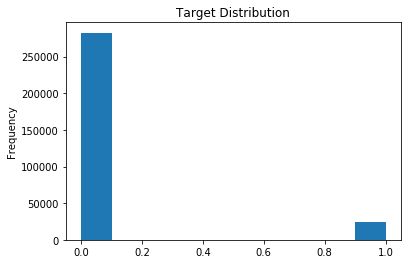

In [113]:
# imbalanced data
data['TARGET'].astype(int).plot.hist()
plt.title('Target Distribution')

### Plot of AMT_CREDIT

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


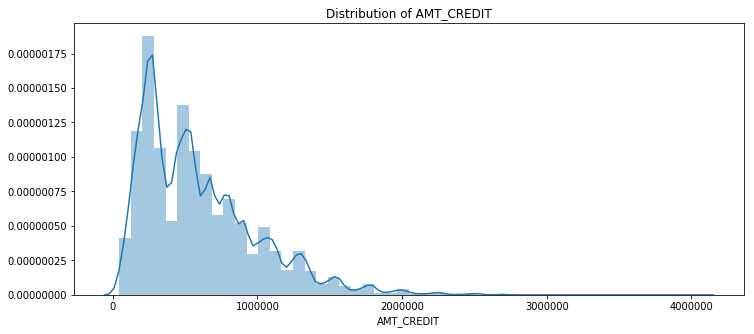

In [114]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(data["AMT_CREDIT"])

## Train-Test Split

In [115]:
X = data.loc[:, data.columns != 'TARGET']
y = data.loc[:, data.columns == 'TARGET']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [117]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (215257, 125)
Number transactions y_train dataset:  (215257, 1)
Number transactions X_test dataset:  (92254, 125)
Number transactions y_test dataset:  (92254, 1)


## Preprocessing

### Missing values

In [120]:
def check_missing_values(dataframe):
    # Create NA Count DataFrame
    nacount = pd.DataFrame(dataframe.isna().sum())
    nacount.columns = ['Count']
    nacount = nacount[(nacount.T != 0).any()]
    nacount['Percentage(%)'] = nacount['Count']/len(X_train)*100
    return nacount 

In [121]:
nacount = check_missing_values(X_train)

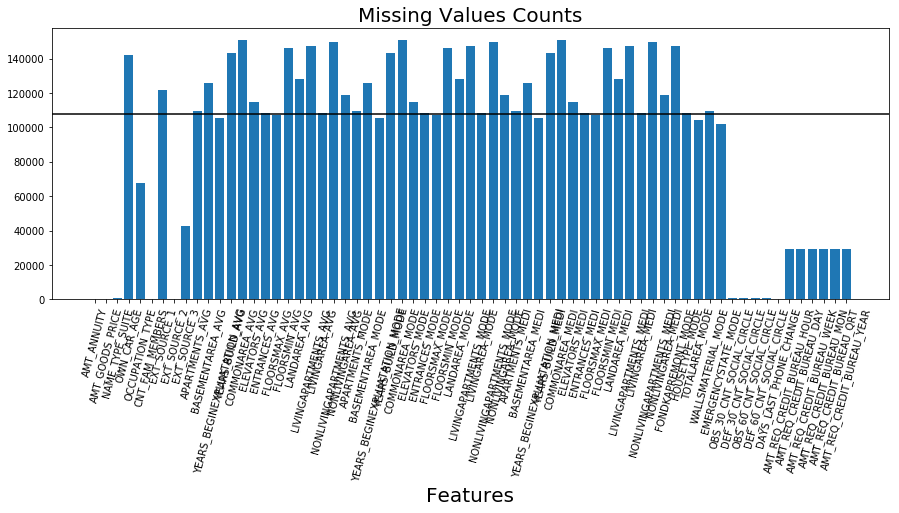

In [122]:
plt.figure(figsize = (15,5))
plt.bar(nacount.index,height = nacount['Count'])
plt.xticks(rotation=75)
plt.xlabel('Features', fontsize = 20)
plt.title('Missing Values Counts', fontsize = 20)
plt.axhline(y=X_train.shape[0]/2, color='black', linestyle='-')
## above: missing more than 50% of data
plt.show()

### Retrieve columns with # missing values > threshold

In [123]:
def filter_out_missing(NAdataframe, threshold):
    nacount_filtered = NAdataframe[NAdataframe['Percentage(%)']>=threshold]
    nacount_sorted = nacount_filtered.sort_index()
    filter_corr = nacount_filtered.index.tolist()
    filter_corr.append("TARGET")
    return nacount_sorted, filter_corr

In [124]:
nacount_sorted

,Count,Percentage(%)
APARTMENTS_AVG,109322,50.786734
APARTMENTS_MEDI,109322,50.786734
APARTMENTS_MODE,109322,50.786734
BASEMENTAREA_AVG,126094,58.578351
BASEMENTAREA_MEDI,126094,58.578351
BASEMENTAREA_MODE,126094,58.578351
COMMONAREA_AVG,150635,69.979141
COMMONAREA_MEDI,150635,69.979141
COMMONAREA_MODE,150635,69.979141
ELEVATORS_AVG,114860,53.359473


In [125]:
# get columns with more than 50% missing
nacount_sorted, filter_corr = filter_out_missing(nacount,50)

In [126]:
X_train_corr_copy = X_train.copy()
X_train_corr_copy['TARGET'] = y_train

In [127]:
filter_corr1 = filter_corr[:21]
filter_corr1.append('TARGET')
filter_corr2 = filter_corr[21:]

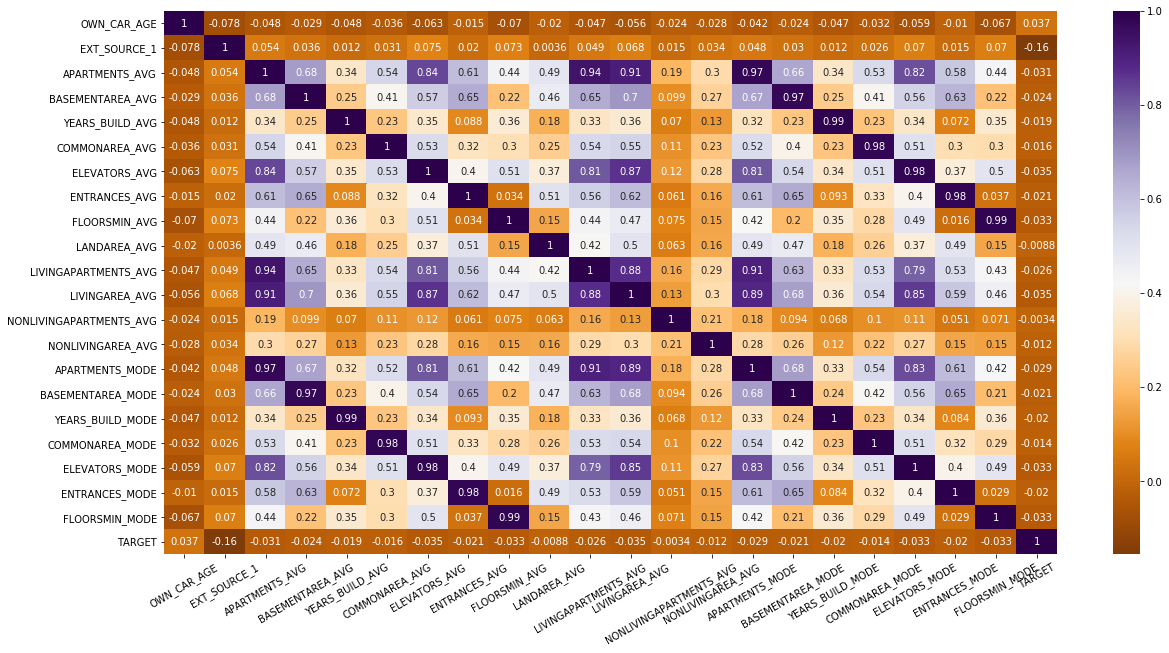

In [128]:
## check correlation for those selected columns
corr1 = X_train_corr_copy[filter_corr1].corr()
fig, ax = plt.subplots(figsize=(20,10))
heatmap = sns.heatmap(corr1, ax=ax, annot=True, cmap="PuOr")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
plt.show()

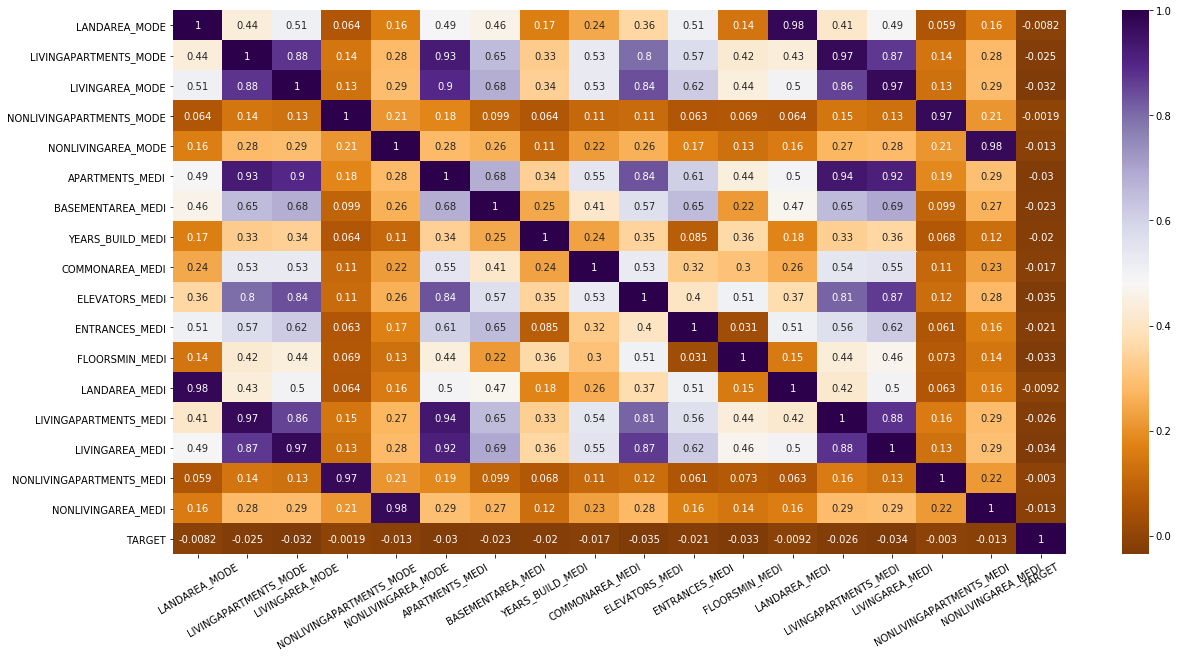

In [129]:
## check correlation for those selected columns
corr2 = X_train_corr_copy[filter_corr2].corr()
fig, ax = plt.subplots(figsize=(20,10))
heatmap = sns.heatmap(corr2, ax=ax, annot=True, cmap="PuOr")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
plt.show()

In [130]:
# From those missing more than 50%, select those features correlated with Target
print(corr1.iloc[-1,:][np.abs(corr1.iloc[-1,:].sort_values()) > 0.1])
# print(corr2.iloc[-1,:][np.abs(corr2.iloc[-1,:].sort_values()) > 0.1])

EXT_SOURCE_1   -0.155797
TARGET          1.000000
Name: TARGET, dtype: float64


In [131]:
filter_corr.remove('EXT_SOURCE_1')
filter_corr.remove('TARGET')

### Drop those columns from train and test; Keep Median values, drop mode and avg

In [132]:
# Keep Median values, drop mode and avg
drop_label = [x for x in filter_corr if 'MEDI' not in x]

In [133]:
def first_drop_stage(dataframe, drop_label):
    dataframe = dataframe.drop(labels = drop_label, axis = 1)
    return dataframe

In [134]:
print(len(drop_label))
print(X_train.shape)

28
(215257, 125)


In [135]:
X_train = first_drop_stage(X_train, drop_label)
X_test = first_drop_stage(X_test, drop_label)

In [136]:
# Drop 28 columns from 121 columns
# 93 remains
print(X_train.shape)
print(X_test.shape)

(215257, 97)
(48744, 93)


### Pickout numeric and categorical features

In [137]:
## Optimize
types_list = ['object', 'int64', 'float64']
def get_type_col(dataframe, types_list):
    type_col = {}
    for i in types_list:        
        type_col[i] = dataframe.dtypes[dataframe.dtypes == i].index.tolist()
    return type_col

type_col = get_type_col(X_train, types_list)


In [138]:
object_type_col = type_col['object']
int64_type_col = type_col['int64']
float64_type_col = type_col['float64']
print('There are {} columns are "object" type'.format(len(object_type_col)))
print('There are {} columns are "int64" type'.format(len(int64_type_col)))
print('There are {} columns are "float64" type'.format(len(float64_type_col)))

There are 13 columns are "object" type
There are 40 columns are "int64" type
There are 44 columns are "float64" type


In [139]:
def get_cat_numeric(dataframe, type_col):
    ## retrieve categorical features from int64_col
    cat_in_int64 = []
    for item in type_col['int64']:
        if ('FLAG_' in item) or ('REG_' in item) or ('LIVE_' in item) or ('HOUR_APPR' in item):
            cat_in_int64.append(item) 
    cat_feature = type_col['object'] + cat_in_int64
    
    # get numerical features
    num_feature = [x for x in dataframe.columns.values.tolist() if x not in cat_feature]
    num_feature.remove('SK_ID_CURR')
    return cat_feature, num_feature

In [140]:
cat_feature, num_feature = get_cat_numeric(X_train, type_col)

In [141]:
print('There are {} numeric feature'.format(len(num_feature)))
print('There are {} categorical feature'.format(len(cat_feature)))

There are 50 numeric feature
There are 46 categorical feature


### Handle missing values in categorical features

In [142]:
# Check missing values inside category features
X_train[cat_feature].isna().sum()

NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
NAME_TYPE_SUITE                   915
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
OCCUPATION_TYPE                 67475
WEEKDAY_APPR_PROCESS_START          0
ORGANIZATION_TYPE                   0
EMERGENCYSTATE_MODE            102186
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE                          0
FLAG_EMAIL                          0
HOUR_APPR_PROCESS_START             0
REG_REGION_NOT_LIVE_REGION          0
REG_REGION_NOT_WORK_REGION          0
LIVE_REGION_NOT_WORK_REGION         0
REG_CITY_NOT_LIVE_CITY              0
REG_CITY_NOT_WORK_CITY              0
LIVE_CITY_NOT_WORK_CITY             0
FLAG_DOCUMEN

In [143]:
### Occupation_type - flag as unknown

In [144]:
## the most missing class - flag as unknown - 67553 missing
## fill missing values with Unknown
print(X_train.isna().sum()['OCCUPATION_TYPE'])
X_train['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
X_test['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

67475


In [145]:
### Emergencystate_mode - drop

In [146]:
## Drop the column - 102265 missing
## check correlation
X_train.isna().sum()['EMERGENCYSTATE_MODE']

102186

In [147]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [148]:
confusion_matrix = pd.crosstab(X_train['EMERGENCYSTATE_MODE'], y_train['TARGET'])
confusion_matrix

TARGET,0,1
EMERGENCYSTATE_MODE,,
No,103769,7689
Yes,1459,154


In [149]:
cramers_corrected_stat(confusion_matrix)

0.011848828215959768

In [150]:
## Drop from both train and test

In [151]:
X_train = X_train.drop(labels = 'EMERGENCYSTATE_MODE', axis = 1)
X_test = X_test.drop(labels = 'EMERGENCYSTATE_MODE', axis = 1)
cat_feature.remove('EMERGENCYSTATE_MODE')

In [152]:
## Name_type_suite - merge the last three minority groups together as 'others'

In [153]:
X_train.isna().sum()['NAME_TYPE_SUITE']

915

In [154]:
X_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      173819
Family              28141
Spouse, partner      8041
Children             2308
Other_B              1241
Other_A               603
Group of people       189
Name: NAME_TYPE_SUITE, dtype: int64

In [155]:
merge_groups_list = X_train['NAME_TYPE_SUITE'].value_counts().index.tolist()[-3:]
def handle_name_type_suite(dataframe, merge_groups_list):
    dataframe['NAME_TYPE_SUITE'].fillna('Others', inplace=True)
    for i in merge_groups_list:
        dataframe['NAME_TYPE_SUITE'].loc[dataframe['NAME_TYPE_SUITE'] == i] = 'Others'

In [156]:
handle_name_type_suite(X_train, merge_groups_list)
handle_name_type_suite(X_test, merge_groups_list)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [157]:
X_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      173819
Family              28141
Spouse, partner      8041
Others               2948
Children             2308
Name: NAME_TYPE_SUITE, dtype: int64

In [158]:
## No missing values in both train and test categorical features

In [159]:
print(X_train[cat_feature].isna().sum().sum())
print(X_test[cat_feature].isna().sum().sum())

0
0


### Handle missing values in numeric features

In [160]:
X_train[num_feature].isna().sum()

CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                          9
AMT_GOODS_PRICE                    192
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
CNT_FAM_MEMBERS                      2
REGION_RATING_CLIENT                 0
REGION_RATING_CLIENT_W_CITY          0
EXT_SOURCE_1                    121485
EXT_SOURCE_2                       452
EXT_SOURCE_3                     42742
YEARS_BEGINEXPLUATATION_AVG     105163
FLOORSMAX_AVG                   107259
YEARS_BEGINEXPLUATATION_MODE    105163
FLOORSMAX_MODE                  107259
APARTMENTS_MEDI                 109415
BASEMENTAREA_MEDI               126059
YEARS_BEGINEXPLUATATION_MEDI    105163
YEARS_BUILD_MEDI                143266
COMMONAREA_MEDI                 150497
ELEVATORS_MEDI           

In [161]:
## ['YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'TOTALAREA_MODE']
## ['YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG'] should be removed
mode_list = [x for x in num_feature if '_MODE' in x]
avg_list = [x for x in num_feature if '_AVG' in x]
drop_label_avg_mode = mode_list + avg_list
X_train = X_train.drop(labels = drop_label_avg_mode, axis = 1)
X_test = X_test.drop(labels = drop_label_avg_mode, axis = 1)

In [162]:
num_feature = [x for x in num_feature if x not in mode_list]
num_feature = [x for x in num_feature if x not in avg_list]

In [163]:
X_train[num_feature].isna().sum()

CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                          9
AMT_GOODS_PRICE                    192
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
CNT_FAM_MEMBERS                      2
REGION_RATING_CLIENT                 0
REGION_RATING_CLIENT_W_CITY          0
EXT_SOURCE_1                    121485
EXT_SOURCE_2                       452
EXT_SOURCE_3                     42742
APARTMENTS_MEDI                 109415
BASEMENTAREA_MEDI               126059
YEARS_BEGINEXPLUATATION_MEDI    105163
YEARS_BUILD_MEDI                143266
COMMONAREA_MEDI                 150497
ELEVATORS_MEDI                  114859
ENTRANCES_MEDI                  108522
FLOORSMAX_MEDI                  107259
FLOORSMIN_MEDI                  146128
LANDAREA_MEDI            

In [164]:
def handle_numerical_features(train_base, dataframe, num_feature):
    for item in num_feature:
        if dataframe[item].isna().sum() != 0:
            dataframe[item].fillna((train_base[item].median()), inplace=True) 

In [ ]:
handle_numerical_features(X_train, X_train, num_feature)
handle_numerical_features(X_train, X_test, num_feature)

In [ ]:
print(X_train[cat_feature].isna().sum().sum())
print(X_test[cat_feature].isna().sum().sum())

## At this stage, all missing values should be handled

In [1286]:
print(X_train.shape)
print(X_test.shape)

(215257, 91)
(92254, 91)


In [1287]:
print(len(cat_feature),len(num_feature))

45 45


## Smote

In [728]:
X_train = X_train.drop(labels = 'SK_ID_CURR', axis = 1)
X_test = X_test.drop(labels = 'SK_ID_CURR', axis = 1)

In [555]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,LATE_PAYMENT,CRED_UTIL_2,DEBT_RATIO,CRED_UTIL_2_missing
125587,Cash loans,M,Y,N,0,153000.0,104256.0,10440.0,90000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,1.0,0.0,13.0,0.0,0.815337,1.0
51500,Cash loans,F,N,Y,0,427500.0,684000.0,31824.0,684000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,1.0,1.0,-19.0,0.0,0.964437,0.0
276439,Revolving loans,F,N,Y,0,135000.0,202500.0,10125.0,202500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.999992,1.0
244558,Cash loans,F,Y,Y,1,270000.0,1502941.5,45567.0,1372500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366725,1.0
98003,Cash loans,F,N,N,0,180000.0,1288350.0,37800.0,1125000.0,Family,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.804157,1.0


In [556]:
print('Shape of X: {}'.format(X_train.shape))
print('Shape of y: {}'.format(y_train.shape))

Shape of X: (215257, 90)
Shape of y: (215257, 1)


In [557]:
print("Before OverSampling, counts of label '1' in training dataset: {}".format(np.sum(y_train==1)[0]))
print("Before OverSampling, counts of label '0' in training dataset: {}".format(np.sum(y_train==0)[0]))

Before OverSampling, counts of label '1' in training dataset: 17485
Before OverSampling, counts of label '0' in training dataset: 197772


In [558]:
## retrieve the index of categorical features
train_features = X_train.columns.tolist()
cat_index = [train_features.index(i) for i in cat_feature]

In [559]:
sm = SMOTENC(random_state=42, categorical_features=cat_index)
X_train, y_train = sm.fit_resample(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [560]:
# pkl.dump(X_train, open("X_train_smote.p", "wb"))
# pkl.dump(y_train, open("y_train_smote.p", "wb"))
X_train = pkl.load(open("X_train_smote.p", "rb"))
y_train = pkl.load(open("X_train_smote.p", "rb"))

In [561]:
X_train = pd.DataFrame(X_train, columns=train_features)
y_train = pd.DataFrame(y_train, columns=['TARGET'], dtype = 'int64')

In [562]:
dtype_dict = dict(zip(X_train.dtypes.index, X_train.dtypes.values))
for k, v in dtype_dict.items():
    X_train[k] = X_train[k].astype(v)

In [563]:
print('After OverSampling, the shape of X: {}'.format(X_train.shape))
print('After OverSampling, the shape of y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(np.sum(y_train==1)[0]))
print("After OverSampling, counts of label '0': {}".format(np.sum(y_train==0)[0]))

After OverSampling, the shape of X: (395544, 90)
After OverSampling, the shape of y: (395544, 1) 

After OverSampling, counts of label '1': 197772
After OverSampling, counts of label '0': 197772


In [564]:
# pkl.dump(X_train, open("X_train_smote_df.p", "wb"))
# pkl.dump(y_train, open("y_train_smote_df.p", "wb"))
X_train = pkl.load(open("X_train_smote_df.p", "rb"))
y_train = pkl.load(open("X_train_smote_df.p", "rb"))

## Create dummy variables

In [1288]:
flag_word_to_number_list = ['FLAG_OWN_CAR', 'CODE_GENDER', 'FLAG_OWN_REALTY']

def handle_word(dataframe, flag_list):
    for item in flag_list:
        if 'Y' in list(dataframe[item]):
            dataframe[item] = dataframe[item].map({'Y': 1, 'N': 0})
        elif 'F' in list(dataframe[item]):
            dataframe[item] = dataframe[item].map({'F': 1, 'M': 0})
    dataframe['CODE_GENDER'].fillna(0, inplace=True)

In [1289]:
def create_dummy(dataframe):
    dummy_feature = [i for i in cat_feature if 'FLAG_' not in i]
    dummy_feature.remove('CODE_GENDER')
    X_prepared = pd.get_dummies(dataframe, columns=dummy_feature)
    return X_prepared

In [1290]:
handle_word(X_train, flag_word_to_number_list)
handle_word(X_test, flag_word_to_number_list)
X_train = create_dummy(X_train)
X_test = create_dummy(X_test)

In [1291]:
print(X_train.shape, X_test.shape)

(215257, 227) (92254, 227)


## Anomalies Detection

In [1292]:
(X_train['DAYS_BIRTH'] / 365).describe()
# seems fine

count    215257.000000
mean        -43.953907
std          11.959165
min         -69.120548
25%         -53.950685
50%         -43.197260
75%         -34.019178
max         -20.517808
Name: DAYS_BIRTH, dtype: float64

In [1293]:
(X_train['DAYS_EMPLOYED']).describe()

count    215257.000000
mean      63906.197099
std      141353.827451
min      -17583.000000
25%       -2760.000000
50%       -1217.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

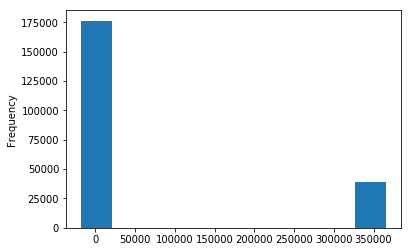

In [1294]:
(X_train['DAYS_EMPLOYED']).plot.hist()

In [1295]:
# There are some extreme values, which is not possible
# Fill with median
X_train['DAYS_EMPLOYED'].replace({1: np.nan}, inplace = True)
X_train['DAYS_EMPLOYED'].fillna(X_train['DAYS_EMPLOYED'].median(), inplace=True)

In [1296]:
(X_train['DAYS_EMPLOYED']).describe()

count    215257.000000
mean      63906.197099
std      141353.827451
min      -17583.000000
25%       -2760.000000
50%       -1217.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [1297]:
# Do the same for test
# fill with train median
X_test['DAYS_EMPLOYED'].replace({1: np.nan}, inplace = True)
X_test['DAYS_EMPLOYED'].fillna(X_train['DAYS_EMPLOYED'].median(), inplace=True)

## Domain Knowledge Feature Extraction

In [1298]:
X_train['CREDIT_INCOME_PERCENT'] = X_train['AMT_CREDIT'] / X_train['AMT_INCOME_TOTAL']
X_train['ANNUITY_INCOME_PERCENT'] = X_train['AMT_ANNUITY'] / X_train['AMT_INCOME_TOTAL']
X_train['CREDIT_TERM'] = X_train['AMT_ANNUITY'] / X_train['AMT_CREDIT']
X_train['DAYS_EMPLOYED_PERCENT'] = X_train['DAYS_EMPLOYED'] / X_train['DAYS_BIRTH']

In [1299]:
X_train['CREDIT_TERM'].fillna(X_train['CREDIT_TERM'].median(), inplace=True)

In [1300]:
X_train['CREDIT_TERM'][X_train['CREDIT_TERM'] == np.inf] = X_train['CREDIT_TERM'].median()
X_train['CREDIT_INCOME_PERCENT'][X_train['CREDIT_INCOME_PERCENT'] == np.inf] = \
X_train['CREDIT_INCOME_PERCENT'].median()
X_train['ANNUITY_INCOME_PERCENT'][X_train['ANNUITY_INCOME_PERCENT'] == np.inf] = \
X_train['ANNUITY_INCOME_PERCENT'].median()
X_train['DAYS_EMPLOYED_PERCENT'][X_train['DAYS_EMPLOYED_PERCENT'] == np.inf] = \
X_train['DAYS_EMPLOYED_PERCENT'].median()


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: Sett

In [1301]:
X_test['CREDIT_INCOME_PERCENT'] = X_test['AMT_CREDIT'] / X_test['AMT_INCOME_TOTAL']
X_test['ANNUITY_INCOME_PERCENT'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']
X_test['CREDIT_TERM'] = X_test['AMT_ANNUITY'] / X_test['AMT_CREDIT']
X_test['DAYS_EMPLOYED_PERCENT'] = X_test['DAYS_EMPLOYED'] / X_test['DAYS_BIRTH']

In [1302]:
(X_train == np.inf).sum().sum()

0

In [1303]:
X_train.isna().sum().sum()

0

## Rescale numeric features

In [1304]:
def feature_normalization(base, dataset, columns_sel):
    dataset[columns_sel] = (dataset[columns_sel] - base[columns_sel].min(axis=0))/ \
    (base[columns_sel].max(axis=0) - base[columns_sel].min(axis=0))
    return dataset

In [1305]:
X_train = feature_normalization(X_train, X_train, num_feature)
X_test = feature_normalization(X_train, X_test, num_feature)

In [1306]:
import time

In [1396]:
start_time = time.time()
columns_name = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
c = list(combinations_with_replacement(columns_name, r=2))
def vec_mul(a,b):
    return a*b
for i in c:
    X_train[i] = vec_mul(X_train[i[0]], X_train[i[1]])
    X_test[i] = vec_mul(X_test[i[0]], X_test[i[1]])  
end_time = time.time()

In [1397]:
print('Total Time Used with Numba Vectorize: ', end_time - start_time, 's')

Total Time Used with Numba Vectorize:  0.043642282485961914 s


In [1393]:
from numba import vectorize, float64
from itertools import combinations_with_replacement

columns_name = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
c = list(combinations_with_replacement(columns_name, r=2))
start_time = time.time()
@vectorize([float64(float64,float64)])
def vec_mul(a,b):
    return a*b
for i in c:
    X_train[i] = vec_mul(X_train[i[0]], X_train[i[1]])
    X_test[i] = vec_mul(X_test[i[0]], X_test[i[1]]) 
end_time = time.time()

In [1395]:
print('Total Time Used without Numba Vectorize: ', end_time - start_time, 's')

Total Time Used without Numba Vectorize:  0.34524011611938477 s


In [1007]:
# pkl.dump(X_train, open("X_train.p", "wb"))
# pkl.dump(y_train, open("y_train.p", "wb"))
# pkl.dump(X_test, open("X_test.p", "wb"))
# pkl.dump(y_test, open("y_test.p", "wb"))

In [1008]:
# X_train.to_csv('preprocessed_train.csv', index = False)
# X_test.to_csv('preprocessed_test.csv', index = False)

In [1009]:
# y_train.to_csv('preprocessed_train_y.csv', index = False)
# y_test.to_csv('preprocessed_test_y.csv', index = False)

## Modeling Stage

In [100]:
X_train = X_train.drop(labels=['previous_NAME_GOODS_CATEGORY_Animals_mean', \
                               'previous_NAME_GOODS_CATEGORY_Animals_sum'], axis=1)

In [101]:
X_train = X_train.drop(labels=['previous_NAME_GOODS_CATEGORY_House Construction_mean', \
                               'previous_NAME_GOODS_CATEGORY_House Construction_sum'], axis=1)

In [106]:
X_test = X_test.drop(labels=['previous_NAME_GOODS_CATEGORY_Animals_mean', \
                               'previous_NAME_GOODS_CATEGORY_Animals_sum'], axis=1)
X_test = X_test.drop(labels=['previous_NAME_GOODS_CATEGORY_House Construction_mean', \
                               'previous_NAME_GOODS_CATEGORY_House Construction_sum'], axis=1)

In [98]:
np.isnan(X_train).sum()[np.isnan(X_train).sum()!=0]

previous_NAME_GOODS_CATEGORY_Animals_mean               215257
previous_NAME_GOODS_CATEGORY_Animals_sum                215257
previous_NAME_GOODS_CATEGORY_House Construction_mean    215257
previous_NAME_GOODS_CATEGORY_House Construction_sum     215257
dtype: int64

In [1309]:
def plot_roc(y_test, y_pred_prob, y_pred, method):
    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob)
    auc1 = auc(fpr1,tpr1)
    plt.plot(fpr1,tpr1,label = 'AUC for {}'.format(method))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.plot([0, 1], [0, 1], 'b--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    print('AUC score for {} is: {}'.format(method, metrics.roc_auc_score(y_test, y_pred_prob)))
#     print('The recall for {} method is: {}'.format(method,metrics.recall_score(y_test, y_pred)))

In [1310]:
weight_0 = np.sum(y_train['TARGET']==0) / (np.sum(y_train['TARGET']==0) + np.sum(y_train['TARGET']==1))
weight_1 = 1 - weight_0

### Naive Bayes --- assumes indenpendent features

In [1091]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [1095]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

AUC score for Naive Bayes is: 0.562100401117489


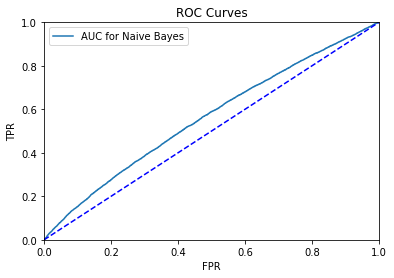

In [584]:
plot_roc(y_test, y_pred_prob, y_pred, 'Naive Bayes')

### SVM --- take too long

In [274]:
from sklearn import svm

In [275]:
# clf = svm.SVC(kernel='linear') 
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [1124]:
# print("AUC:", metrics.roc_auc_score(y_test, y_pred))

### Random Forest

In [1402]:
from sklearn.ensemble import RandomForestClassifier

In [1403]:
random_forest = RandomForestClassifier(n_estimators = 100, max_depth=5,min_samples_split=10)

In [1404]:
random_forest.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1405]:
# Make predictions on the test data
y_pred = random_forest.predict(X_test)
y_pred_prob = random_forest.predict_proba(X_test)

In [1362]:
metrics.recall_score(y_test, predicted)

0.8762942779291553

AUC score for Random Forest is: 0.7156391040680428


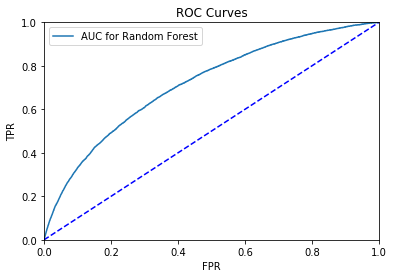

In [1408]:
plot_roc(y_test, y_pred_prob[:, 1], y_pred, 'Random Forest')

In [588]:
# Make predictions on the test data
y_pred_rf = random_forest.predict(X_test)
y_pred_prob_rf = random_forest.predict_proba(X_test)[:, 1]

AUC score for Naive Bayes is: 0.562100401117489
AUC score for Random Forest is: 0.630095041182555


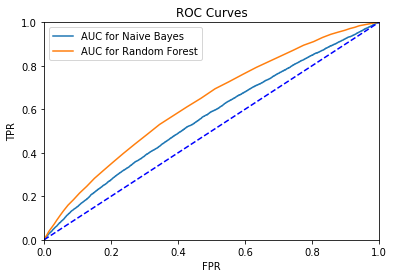

In [589]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob_rf)
auc1 = auc(fpr1,tpr1)
auc2 = auc(fpr2,tpr2)
plt.plot(fpr1,tpr1,label = 'AUC for {}'.format('Naive Bayes'))
plt.plot(fpr2,tpr2,label = 'AUC for {}'.format('Random Forest'))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
print('AUC score for {} is: {}'.format('Naive Bayes', metrics.roc_auc_score(y_test, y_pred_prob)))
print('AUC score for {} is: {}'.format('Random Forest', metrics.roc_auc_score(y_test, y_pred_prob_rf)))
#     print('The recall for {} method is: {}'.format(method,metrics.recall_score(y_test, y_pred)))

### LightGBM

In [1364]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [1365]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [1366]:
params = {
     'task': 'train',
     'objective':'binary',
     'metric': 'auc',
     'verbose': 0,
     'binary'
     'max_bin': 128,  # 大会有更准的效果,更慢的速度
     'learning_rate': 0.01,  # 学习率
     'num_leaves': 100,  # 大会更准,但可能过拟合
     'num_iterations': 100,
     'early_stopping_round': 5,
     'min_data_in_leaf': 5,
     'max_depth': 10,
    }

In [1367]:
gbm = lgb.train(params,lgb_train, valid_sets = [lgb_eval], verbose_eval = False)
print(gbm.best_score['valid_0'])

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


{'auc': 0.7154864540298795}


In [1368]:
y_pred = gbm.predict(X_test)

In [1390]:
print('Recall score for LightGBM model is: {}'.format(metrics.recall_score(y_train, predicted)))

Recall score for LightGBM model is: 0.8228767515012868


In [1045]:
def plot_confusion_matrix(cm, title, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)     
    plt.title(title)       
    plt.colorbar()     
    tick_marks = np.arange(len(classes))       
    plt.xticks(tick_marks, classes, rotation=45)       
    plt.yticks(tick_marks, classes)        

    thresh = cm.max() / 2.        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):     
        plt.text(j, i, format(cm[i, j], 'd'),      
        horizontalalignment="center",     
        color="white" if cm[i, j] > thresh else "black")      

    plt.tight_layout()        
    plt.ylabel('True label')       
    plt.xlabel('Predicted label')

In [378]:
num_leaves = [50, 100, 200, 300, 400]
min_data_in_leaf = [10, 20, 30, 40, 50]
max_depth = [10, 15, 20, 50, 100]
# learning_rate = [0.0001,0.0005, 0.001,0.005, 0.01]

In [379]:
param = [((ia, ib, ic), (a, b, c)) for ia, a in enumerate(num_leaves) 
        for ib, b in enumerate(min_data_in_leaf)
        for ic, c in enumerate(max_depth)]

In [383]:
score = np.zeros([5,5,5,5])

In [384]:
from tqdm import tqdm_notebook as tqdm

In [385]:
for (ia, ib, ic), (a, b, c) in tqdm(param):
    params = {
     'task': 'train',
     'objective':'regression',
     'metric': 'auc',
     'verbose': 0,

     'max_bin': 128,  # 大会有更准的效果,更慢的速度
     'learning_rate': 0.01,  # 学习率
     'num_leaves': a,  # 大会更准,但可能过拟合
     'num_iterations': 1000,
     'early_stopping_round': 5,
     'min_data_in_leaf': b,
     'max_depth': c,
    }
#     print('Running {}-{}-{}, {}/343'.format(ia, ib, ic, (ia)*49 + (ib) * 7 + ic + 1))
    gbm = lgb.train(params,
                    lgb_train, valid_sets = [lgb_eval], verbose_eval = False)
    print((a,b,c), gbm.best_score['valid_0'])
    score[ia, ib, ic] = gbm.best_score['valid_0']['auc']
#     print('Score is {}'.format(gbm.best_score['valid_0']['l2_root']))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 10, 10) {'auc': 0.71958647181354}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 10, 15) {'auc': 0.7185945674543355}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 10, 20) {'auc': 0.7185945674543355}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 10, 50) {'auc': 0.7185945674543355}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 10, 100) {'auc': 0.7185945674543355}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 20, 10) {'auc': 0.7196949916116444}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 20, 15) {'auc': 0.7185939176544001}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 20, 20) {'auc': 0.7185939176544001}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 20, 50) {'auc': 0.7185939176544001}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 20, 100) {'auc': 0.7185939176544001}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 30, 10) {'auc': 0.7211385959726266}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 30, 15) {'auc': 0.7185718894365891}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 30, 20) {'auc': 0.7185718894365891}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 30, 50) {'auc': 0.7185718894365891}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 30, 100) {'auc': 0.7185718894365891}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 40, 10) {'auc': 0.7192994351265095}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 40, 15) {'auc': 0.7181932726742152}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 40, 20) {'auc': 0.7181932726742152}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 40, 50) {'auc': 0.7181932726742152}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 40, 100) {'auc': 0.7181932726742152}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 50, 10) {'auc': 0.7190547036241637}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 50, 15) {'auc': 0.7187605825133928}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 50, 20) {'auc': 0.7187605825133928}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 50, 50) {'auc': 0.7187605825133928}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(50, 50, 100) {'auc': 0.7187605825133928}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 10, 10) {'auc': 0.7208169434001473}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 10, 15) {'auc': 0.7213210084522766}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 10, 20) {'auc': 0.7213210084522766}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 10, 50) {'auc': 0.7213210084522766}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 10, 100) {'auc': 0.7213210084522766}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 20, 10) {'auc': 0.720313008308005}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 20, 15) {'auc': 0.7213787676443145}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 20, 20) {'auc': 0.7213827755461384}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 20, 50) {'auc': 0.7213827755461384}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 20, 100) {'auc': 0.7213827755461384}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 30, 10) {'auc': 0.7210453641218918}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 30, 15) {'auc': 0.7202009916235814}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 30, 20) {'auc': 0.7208242805238626}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 30, 50) {'auc': 0.7208242805238626}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 30, 100) {'auc': 0.7208242805238626}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 40, 10) {'auc': 0.7211575516796318}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 40, 15) {'auc': 0.7214065405748878}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 40, 20) {'auc': 0.7218294712861912}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 40, 50) {'auc': 0.7218294712861912}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 40, 100) {'auc': 0.7218294712861912}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 50, 10) {'auc': 0.7214655263645815}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 50, 15) {'auc': 0.7214776206656018}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 50, 20) {'auc': 0.7215612234439602}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 50, 50) {'auc': 0.7215612234439602}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(100, 50, 100) {'auc': 0.7215612234439602}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 10, 10) {'auc': 0.7134125806337542}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 10, 15) {'auc': 0.7158792356286235}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 10, 20) {'auc': 0.7151928014168398}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 10, 50) {'auc': 0.7151345063404109}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 10, 100) {'auc': 0.7151345063404109}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 20, 10) {'auc': 0.7155039553081403}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 20, 15) {'auc': 0.718124420354391}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 20, 20) {'auc': 0.7184885722493134}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 20, 50) {'auc': 0.7184885706448692}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 20, 100) {'auc': 0.7184885706448692}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 30, 10) {'auc': 0.7205074132064633}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 30, 15) {'auc': 0.7176175443158742}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 30, 20) {'auc': 0.7174577801717512}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 30, 50) {'auc': 0.7174056068524917}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 30, 100) {'auc': 0.7174056068524917}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 40, 10) {'auc': 0.7198872674125365}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 40, 15) {'auc': 0.7173362451216069}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 40, 20) {'auc': 0.7179571369821263}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 40, 50) {'auc': 0.717938292783999}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 40, 100) {'auc': 0.717938292783999}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 50, 10) {'auc': 0.7205449203005136}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 50, 15) {'auc': 0.7201234969646161}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 50, 20) {'auc': 0.7235712848819825}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 50, 50) {'auc': 0.720199435312625}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(200, 50, 100) {'auc': 0.720199435312625}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 10, 10) {'auc': 0.7019944261284651}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 10, 15) {'auc': 0.7117950272367253}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 10, 20) {'auc': 0.7117806722737074}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 10, 50) {'auc': 0.7143813585330347}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 10, 100) {'auc': 0.7143813585330347}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 20, 10) {'auc': 0.709933166712864}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 20, 15) {'auc': 0.715950655861526}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 20, 20) {'auc': 0.7160608170061339}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 20, 50) {'auc': 0.7156254510493997}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 20, 100) {'auc': 0.7156254510493997}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 30, 10) {'auc': 0.7128273940763532}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 30, 15) {'auc': 0.7151250088324658}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 30, 20) {'auc': 0.716436692575447}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 30, 50) {'auc': 0.7166614760219974}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 30, 100) {'auc': 0.7166614760219974}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 40, 10) {'auc': 0.7115505644787973}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 40, 15) {'auc': 0.7159715738038916}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 40, 20) {'auc': 0.722899009891014}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 40, 50) {'auc': 0.7213416271657832}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 40, 100) {'auc': 0.7213416271657832}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 50, 10) {'auc': 0.7077387185264989}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 50, 15) {'auc': 0.7243380672568925}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 50, 20) {'auc': 0.7156595511060109}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 50, 50) {'auc': 0.7204172506576456}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(300, 50, 100) {'auc': 0.7204172506576456}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 10, 10) {'auc': 0.6977111784007913}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 10, 15) {'auc': 0.7115728742765801}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 10, 20) {'auc': 0.7122859759568247}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 10, 50) {'auc': 0.7119967171144596}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 10, 100) {'auc': 0.7119967171144596}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 20, 10) {'auc': 0.7115650405773586}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 20, 15) {'auc': 0.7113435735171453}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 20, 20) {'auc': 0.7133119234148684}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 20, 50) {'auc': 0.7138828472647979}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 20, 100) {'auc': 0.7138828472647979}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 30, 10) {'auc': 0.7077809779845214}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 30, 15) {'auc': 0.7134512244765805}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 30, 20) {'auc': 0.7130069554585088}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 30, 50) {'auc': 0.713052174314015}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 30, 100) {'auc': 0.713052174314015}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 40, 10) {'auc': 0.7050758592489057}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 40, 15) {'auc': 0.7129301659528067}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 40, 20) {'auc': 0.7204375524934059}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 40, 50) {'auc': 0.7172188094266108}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 40, 100) {'auc': 0.7172188094266108}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 50, 10) {'auc': 0.7011484531969804}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 50, 15) {'auc': 0.7093655343803851}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 50, 20) {'auc': 0.7180145151186464}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 50, 50) {'auc': 0.7137129871550116}


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(400, 50, 100) {'auc': 0.7137129871550116}



Text(0,0.5,'AUC')

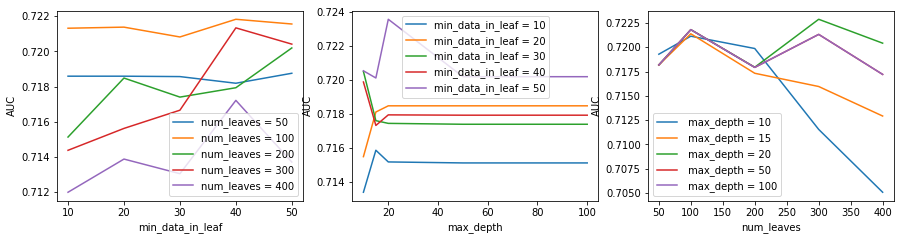

In [387]:
# from matplotlib import rc
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.figure(figsize=(15, 3.5))
# Subplot 1
plt.subplot(1, 3, 1)
for ia, a in enumerate(num_leaves):
    plt.plot(min_data_in_leaf, score_new[ia, :, 3, 3], label = 'num_leaves = ' + str(a))
plt.legend()
plt.xlabel('min_data_in_leaf')
plt.ylabel('AUC')

# Subplot 2
plt.subplot(1, 3, 2)
for ia, a in enumerate(min_data_in_leaf):
    plt.plot(max_depth, score_new[2, ia, :, 2], label = 'min_data_in_leaf = ' + str(a))
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('AUC')

# Subplot 3
plt.subplot(1, 3, 3)
for ia, a in enumerate(max_depth):
    plt.plot(num_leaves, score_new[:, 3, ia, 3], label = ' max_depth = ' + str(a))
plt.legend()
plt.xlabel('num_leaves')
plt.ylabel('AUC')

In [ ]:
## Best --- Max_depth = 20; Min_data_in_leaf = 50; num_leaves = 100; 

In [1211]:
params = {
 'task': 'train',
 'objective':'regression',
 'metric': 'auc',
 'verbose': 0,

 'max_bin': 128,  
 'learning_rate': 0.01,  
 'num_leaves': 100,  
 'num_iterations': 1000,
 'early_stopping_round': 5,
 'min_data_in_leaf': 50,
 'max_depth': 20,
}
gbm = lgb.train(params, lgb_train, valid_sets = [lgb_eval], verbose_eval = False)
print('The current best hyper-parameter is: (Max_depth = {}, Min_data_in_leaf = {}, Num_leaves = {})'.format(20,50,100))
print('AUC score after hyper-parameter tuning for LightGBM model is: {}'.format(gbm.best_score['valid_0']['auc']))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


The current best hyper-parameter is: (Max_depth = 20, Min_data_in_leaf = 50, Num_leaves = 100)
AUC score after hyper-parameter tuning for LightGBM model is: 0.7215612234439602


In [594]:
y_labels = [gbm.feature_name()[i] for i in np.argsort(gbm.feature_importance())]

In [615]:
gbm.feature_name()

['SK_ID_CURR',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUME

In [630]:
importance_dict = {}

In [631]:
for i in np.argsort(-gbm.feature_importance()):
    importance_dict[gbm.feature_name()[i]] = gbm.feature_importance()[i]

In [632]:
importance_dict

{'DEBT_RATIO': 250,
 "('EXT_SOURCE_2',_'EXT_SOURCE_3')": 240,
 'CRED_UTIL_2': 218,
 'DAYS_BIRTH': 188,
 'EXT_SOURCE_1': 179,
 "('EXT_SOURCE_1',_'EXT_SOURCE_3')": 175,
 'CREDIT_TERM': 164,
 "('EXT_SOURCE_1',_'EXT_SOURCE_2')": 142,
 'ANNUITY_INCOME_PERCENT': 101,
 'LATE_PAYMENT': 100,
 'AMT_GOODS_PRICE': 98,
 'DAYS_EMPLOYED_PERCENT': 93,
 'AMT_ANNUITY': 87,
 'CODE_GENDER': 83,
 'NAME_EDUCATION_TYPE_Higher_education': 81,
 "('EXT_SOURCE_1',_'DAYS_BIRTH')": 76,
 'EXT_SOURCE_2': 65,
 "('EXT_SOURCE_2',_'DAYS_BIRTH')": 61,
 'DAYS_EMPLOYED': 57,
 'DAYS_LAST_PHONE_CHANGE': 56,
 'CREDIT_INCOME_PERCENT': 55,
 "('EXT_SOURCE_3',_'DAYS_BIRTH')": 51,
 'AMT_CREDIT': 48,
 'EXT_SOURCE_3': 48,
 'NAME_EDUCATION_TYPE_Secondary_/_secondary_special': 43,
 'DAYS_REGISTRATION': 43,
 'NAME_INCOME_TYPE_Working': 40,
 'FLAG_DOCUMENT_3': 34,
 'DAYS_ID_PUBLISH': 33,
 'REGION_POPULATION_RELATIVE': 31,
 'LIVINGAREA_MEDI': 29,
 'SK_ID_CURR': 29,
 'BASEMENTAREA_MEDI': 24,
 'APARTMENTS_MEDI': 23,
 'REG_CITY_NOT_LIVE_CIT

In [646]:
importance = np.abs(sorted(-gbm.feature_importance())[:10])
name = list(importance_dict.keys())[:10]

In [648]:
name

['DEBT_RATIO',
 "('EXT_SOURCE_2',_'EXT_SOURCE_3')",
 'CRED_UTIL_2',
 'DAYS_BIRTH',
 'EXT_SOURCE_1',
 "('EXT_SOURCE_1',_'EXT_SOURCE_3')",
 'CREDIT_TERM',
 "('EXT_SOURCE_1',_'EXT_SOURCE_2')",
 'ANNUITY_INCOME_PERCENT',
 'LATE_PAYMENT']

In [649]:
importance

array([250, 240, 218, 188, 179, 175, 164, 142, 101, 100])

In [652]:
feature_importances_domain = pd.DataFrame({'feature': name,'importance': importance})

In [656]:
# Citation: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Baseline
def plot_feature_importances(df):

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

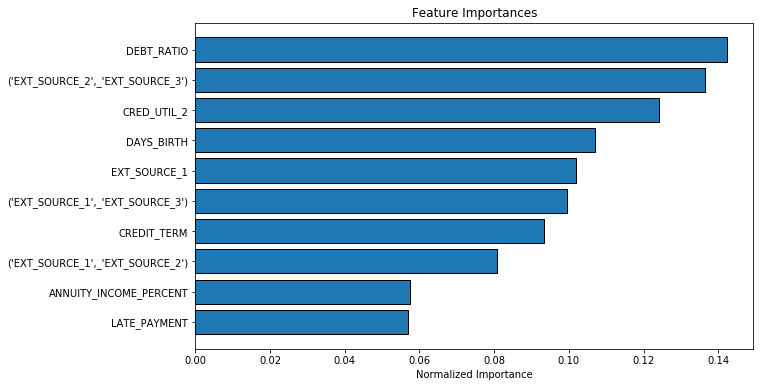

In [658]:
feature_importances_sorted = plot_feature_importances(feature_importances_domain)

## MPI for LightGBM

In [162]:
import itertools
param =[[x,y,z] for x,y,z in itertools.product(num_leaves, min_data_in_leaf, max_depth)]

In [209]:
param

[(50, 5, 5), (50, 5, 7), (100, 5, 5), (100, 5, 7)]

In [241]:
%%writefile lightgbm_parallel.py

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
import pickle as pkl
import numpy as np
import lightgbm as lgb
import itertools
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

X_train = pkl.load(open("X_train.p", "rb"))
y_train = pkl.load(open("y_train.p", "rb"))
X_test = pkl.load(open("X_test.p", "rb"))
y_test = pkl.load(open("y_test.p", "rb"))

lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

num_leaves = [50, 100]
min_data_in_leaf = [5]
max_depth = [5, 7]

param =[(x,y,z) for x,y,z in itertools.product(num_leaves, min_data_in_leaf, max_depth)]
auc_list = []
best = np.zeros(4)

if rank != 0:
    param_in_rank = param[rank]
    params = {
     'task': 'train',
     'objective':'binary',
     'metric': 'auc',
     'verbose': 0,
     'max_bin': 128,  # 大会有更准的效果,更慢的速度
     'learning_rate': 0.01,  # 学习率
     'num_leaves': param_in_rank[0],  # 大会更准,但可能过拟合
     'num_iterations': 50,
     'early_stopping_round': 5,
     'min_data_in_leaf': param_in_rank[1],
     'max_depth': param_in_rank[2],
    }
    gbm = lgb.train(params, lgb_train, valid_sets = [lgb_eval], verbose_eval = False)
    best_score = gbm.best_score['valid_0']['auc']
    best[0] = best_score
    best[1] = param_in_rank[0]
    best[2] = param_in_rank[1]
    best[3] = param_in_rank[2]
    comm.Send(best, dest=0)
        
if rank == 0:
    param_in_rank = param[rank]
    params = {
     'task': 'train',
     'objective':'binary',
     'metric': 'auc',
     'verbose': 0,
     'max_bin': 128,  # 大会有更准的效果,更慢的速度
     'learning_rate': 0.01,  # 学习率
     'num_leaves': param_in_rank[0],  # 大会更准,但可能过拟合
     'num_iterations': 50,
     'early_stopping_round': 5,
     'min_data_in_leaf': param_in_rank[1],
     'max_depth': param_in_rank[2],
    }
    gbm = lgb.train(params, lgb_train, valid_sets = [lgb_eval], verbose_eval = False)
    best_score = gbm.best_score['valid_0']['auc']
    best[0] = best_score
    best[1] = param_in_rank[0]
    best[2] = param_in_rank[1]
    best[3] = param_in_rank[2]
    print('Rank: ', rank, 'receives hyperparameters: ', '({},{},{})'.format(best[1],best[2],best[3]),\
          'and get AUC score: ', best[0])
    for i in range(1,size):
        comm.Recv(best, source=i)
        print('Rank: ', i, 'receives hyperparameters: ', '({},{},{})'.format(best[1],best[2],best[3]),\
              'and get AUC score: ', best[0])

Overwriting lightgbm_parallel.py


In [223]:
auc_list = [[1,44,4,5],[2,55,4,6,],[77,2,3,4]]

In [224]:
max(auc_list, key=lambda x: x[3])

[2, 55, 4, 6]